In [1]:
# pytorch
import torch
import torch.nn as nn
# Mobile Net
# from MobileNetV2 import mobilenet_v2
from MobileNetV3 import mobilenetv3_large, mobilenetv3_small
# dataset
from torchvision import datasets
from torchvision import transforms
# dataloader
from torch.utils.data import DataLoader
# Util
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
# tensorboard
from torch.utils.tensorboard import SummaryWriter
# plt
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
matplotlib.rcParams.update({'font.size': 13})
import scipy.io as scio
from scipy.io import loadmat
from sklearn.model_selection import KFold

In [2]:
# loss下降曲线vec
vec1 = [] #0.01
vec2 = [] #0.005
vec3 = [] #0.001
vec4 = [] #0.0005

In [3]:
# 超参数
input_size = 224
batch_size = 32
n_worker = 8
lr = 0.001
epochs = 80

In [4]:
# 生成训练数据集
train_path = "image/train_image"
test_path = "image/train_image"
val_path = "image/val_image"
data_transform = transforms.Compose([
        transforms.Resize([input_size, input_size]),
        transforms.ToTensor(),
])
train_dataset = datasets.ImageFolder(train_path, transform=data_transform)
test_dataset = datasets.ImageFolder(test_path, transform=data_transform)
val_dataset = datasets.ImageFolder(val_path, transform=data_transform)

In [5]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=n_worker, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=20, shuffle=False, 
    num_workers=n_worker)
val_loader = DataLoader(
    val_dataset, batch_size=5, shuffle=False, 
    num_workers=n_worker)

In [6]:
model = mobilenetv3_large()
# model = mobilenet_v2()
model.classifier[3] = nn.Linear(1280, 90)
model = model.cuda(3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
best_model_wts = copy.deepcopy(model.state_dict())
# writer = SummaryWriter()

In [7]:
def train(epoch, model):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(3), label.cuda(3)
        # clear the grad
        optimizer.zero_grad()
        output = model(data)
        # loss function
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    # writer.add_scalar("Loss/train", train_loss, epoch)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [8]:
def val(epoch, model):       
    model.eval()
    idx = 0
    ans = 0.0
    best_acc = 0.0
    ri_ct = 0.0
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.cuda(3), label.cuda(3)
            output = model(data)
            preds = torch.argmax(output, 1)
            ri_ct += (preds == idx).sum().item()
            unique_values, counts = torch.unique(preds, return_counts=True)
            pres = unique_values[counts.argmax()]
            if pres.item() == idx:
                ans += 1
            idx += 1
    acc = ans / 90
    r = ri_ct / 540
    print('Epoch: {} Val Accuracy: {:6f}'.format(epoch, acc))
    print('Epoch: {} Val Recall: {:6f}'.format(epoch, r))
    return acc, r

In [9]:
def test(epoch, model):
    model.eval()
    idx = 0
    ans = 0.0
    best_acc = 0.0
    ri_ct = 0.0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.cuda(3), label.cuda(3)
            output = model(data)
            preds = torch.argmax(output, 1)
            ri_ct += (preds == idx).sum().item()
            unique_values, counts = torch.unique(preds, return_counts=True)
            pres = unique_values[counts.argmax()]
            if pres.item() == idx:
                ans += 1
            idx += 1
    acc = ans / 90
    r = ri_ct / 1800
    if acc > best_acc:
        best_model_wts = copy.deepcopy(model.state_dict())
    print('Epoch: {} Test Accuracy: {:6f}'.format(epoch, acc))
    print('Epoch: {} Test Recall: {:6f}'.format(epoch, r))
    return acc, r

In [10]:
start_time = time.time()
val_acc, val_r = 0.0, 0.0
test_acc, test_r = 0.0, 0.0
for epoch in range(1, epochs + 1):
    train(epoch, model)
    acc, r = val(epoch, model)
    val_acc, val_r = max(acc, val_acc), max(r, val_r)
    acc, r = test(epoch, model)
    test_acc, test_r = max(acc, test_acc), max(r, test_r)
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Training time {total_time_str}")
print('Test Acc: {:6f} Test Recall: {:6f}'.format(test_acc, test_r))
print('Val Acc: {:6f} Val Recall: {:6f}'.format(val_acc, val_r))

Epoch: 1 	Training Loss: 4.202651
Epoch: 1 Val Accuracy: 0.022222
Epoch: 1 Val Recall: 0.016667
Epoch: 1 Test Accuracy: 0.011111
Epoch: 1 Test Recall: 0.013889
Epoch: 2 	Training Loss: 3.465046
Epoch: 2 Val Accuracy: 0.088889
Epoch: 2 Val Recall: 0.077778
Epoch: 2 Test Accuracy: 0.111111
Epoch: 2 Test Recall: 0.094444
Epoch: 3 	Training Loss: 2.991243
Epoch: 3 Val Accuracy: 0.133333
Epoch: 3 Val Recall: 0.118519
Epoch: 3 Test Accuracy: 0.211111
Epoch: 3 Test Recall: 0.172222
Epoch: 4 	Training Loss: 2.590376
Epoch: 4 Val Accuracy: 0.122222
Epoch: 4 Val Recall: 0.105556
Epoch: 4 Test Accuracy: 0.233333
Epoch: 4 Test Recall: 0.176111
Epoch: 5 	Training Loss: 2.329601
Epoch: 5 Val Accuracy: 0.266667
Epoch: 5 Val Recall: 0.209259
Epoch: 5 Test Accuracy: 0.400000
Epoch: 5 Test Recall: 0.312222
Epoch: 6 	Training Loss: 1.983463
Epoch: 6 Val Accuracy: 0.477778
Epoch: 6 Val Recall: 0.307407
Epoch: 6 Test Accuracy: 0.611111
Epoch: 6 Test Recall: 0.506667
Epoch: 7 	Training Loss: 1.836859
Epoch:

Epoch: 51 	Training Loss: 0.170132
Epoch: 51 Val Accuracy: 0.722222
Epoch: 51 Val Recall: 0.518519
Epoch: 51 Test Accuracy: 1.000000
Epoch: 51 Test Recall: 0.965556
Epoch: 52 	Training Loss: 0.072549
Epoch: 52 Val Accuracy: 0.777778
Epoch: 52 Val Recall: 0.527778
Epoch: 52 Test Accuracy: 1.000000
Epoch: 52 Test Recall: 0.983333
Epoch: 53 	Training Loss: 0.120120
Epoch: 53 Val Accuracy: 0.888889
Epoch: 53 Val Recall: 0.609259
Epoch: 53 Test Accuracy: 1.000000
Epoch: 53 Test Recall: 0.988333
Epoch: 54 	Training Loss: 0.064833
Epoch: 54 Val Accuracy: 0.877778
Epoch: 54 Val Recall: 0.601852
Epoch: 54 Test Accuracy: 1.000000
Epoch: 54 Test Recall: 0.983333
Epoch: 55 	Training Loss: 0.131218
Epoch: 55 Val Accuracy: 0.811111
Epoch: 55 Val Recall: 0.538889
Epoch: 55 Test Accuracy: 0.988889
Epoch: 55 Test Recall: 0.940556
Epoch: 56 	Training Loss: 0.132681
Epoch: 56 Val Accuracy: 0.833333
Epoch: 56 Val Recall: 0.562963
Epoch: 56 Test Accuracy: 1.000000
Epoch: 56 Test Recall: 0.983889
Epoch: 57 

In [11]:
start_time = time.time()
test(1, model)
total_time = time.time() - start_time
print(total_time)

Epoch: 1 Test Accuracy: 1.000000
Epoch: 1 Test Recall: 0.991111
2.138561964035034


ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

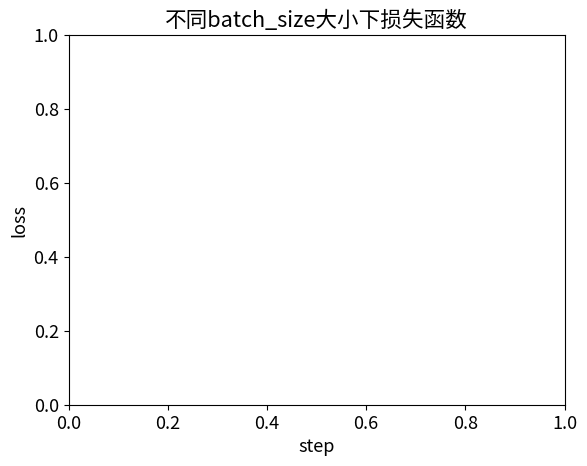

In [12]:
# show train pic
plt.ylabel("loss")
plt.xlabel("step")
plt.title("不同batch_size大小下损失函数")
# plt.plot(list(range(1, 23)), loss_vec4, label='batch_size=4')
plt.plot(list(range(1, 51)), vec1, label='lr=0.01')
plt.plot(list(range(1, 51)), vec2, label='lr=0.005')
plt.plot(list(range(1, 51)), vec3, label='lr=0.001')
plt.plot(list(range(1, 51)), vec4, label='lr=0.0005')
plt.legend()
plt.show()
# matrix = np.mat([loss_vec4, loss_vec8, loss_vec16, loss_vec32])
# scio.savemat('batch_size.mat', {'data': matrix})

In [ ]:
# 训练结果图
plt.ylabel("loss")
plt.xlabel("step")
plt.plot(list(range(1, 81)), loss_vec32)
plt.show()

plt.ylabel("Acc")
plt.xlabel("step")
plt.plot(list(range(1, 81)), acc_vec)
plt.show()

In [14]:
s = time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())
torch.save(best_model_wts, f'save_model/float/ecgid_model_{s}.pt')